<a href="https://colab.research.google.com/github/Romanvia93/traffic_sign_detection/blob/main/yolo/notebooks/Yolov5_w_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Traffic Sign Detection Project Report
* Thien An Trinh
* Roman Burekhin
* Athira Devan
* Lester Azinge

## Abstract

This project aims to train, benchmark and deloy an object detection model to detect 4 types of traffic signs: `traffic light`, `stop`, `speed limit`, and `crosswalk`. The chosen models for the project were `YOLOv5`, `EfficientDet D1`, `SSD MobileNet FPNLite`, `SSD ResNet50 FPN`, and `Faster R-CNN ResNet50`. There are two frameworks for model training, evaluation and inference: `YOLOv5` belongs to [Ultralytics](https://github.com/ultralytics/yolov5) and the rest belong to [Tensorflow](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md). Our experiments showed that among the tested models, `YOLOv5` is the best - It won in all criteria including precision, speed, size, and training time, and therefore  was chosen for a video inference (available in `yolo/videos` directory) and a [Streamlit deployment](https://trafficsigns.streamlit.app/). Besides, among the TensorFlow models, `SSD MobileNet FPNLite` is the best model. Hence, it was chosen to run a realtime webcam test on a local machine. The screen recording of this demo is available in `tensorflow/videos` directory.

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

## 1. Introduction

### 1.1. Problem Statement

We are living in a world that is moving towards automation. From robot arms assembling individual components into complete cars to smart household appliances that have been transforming our homes, the benefits of autonomous applications are undeniable. The automobile industry is following the same trend. Not only autopilot systems assist drivers by bringing them better driving experience, but they can also help reduce the number of accidents. For example, a vehicle with a smart traffic sign detection system can “see” all the signs ahead including those the driver could miss, and thereby perform proper actions timely in time-sensitive situation.

In that context, our project focused two paramount objectives: (1) to meticulously **benchmark** a range of model architectures to identify the most optimal and efficient solution for this challenging task, and (2) to **deploy** and demonstrate precise and reliable detection of critical traffic signs.  

Before proceeding into further detail, it is crucial to address certain concepts related to how the task was framed:
1. The project is a `computer vision` task – a domain in which images are processed and analyzed in order to extract useful information that can drive decision-making (Arabnia et al., 2018; Yoshida, 2011).  
<br>
2. This project is specifically an `object detection` task where an image was analyzed not for obtaining the semantic meaning of the whole image (i.e., `image classification`), or for segmenting the image into meaningful regions (i.e., `image segmentation`), but rather to identify targeted objects that are present in the images and determine where on the images they are located. In this project, the objects of interest were `traffic lights`, `stop` signs, `speed limit` signs and `crosswalk` signs, which are the fundamental elements that guide drivers and traffic flow. Third, the algorithms required for this task were defined to be *deep learning (DL)  convolutional neural networks (CNNs)* which has always been the state-of-the-art in the domain for a decade.  
<br>
3. The project also leveraged an advanced DL technique called transfer learning, in which neural networks that were pretrained on a large dataset are fine-tuned on the dataset of interest instead of being trained from scratch, and therefore are capable of attaining high evaluation scores in the new domain. The details of the data, pretrained-models, training and evaluation frameworks are now discussed in the following section.


### 1.2. Related Work

The authors took [this YOLOv5 turorial](https://colab.research.google.com/github/ultralytics/yolov5/blob/master/tutorial.ipynb) and [this TensorFlow tutorial](https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/training.html) as the starting point for the work of this project.

## 2. Methodology

### 2.1. Data

#### 2.1.1. Data Source

The data for this project was from [Kaggle](https://www.kaggle.com/datasets/andrewmvd/road-sign-detection). The dataset comprises of two folders, each of which consists of 877 files. The first folder is named **“images”** which contains 877 road sign images in PNG, whereas the other is named **“annotations”** and has 877 corresponding XML files that store the image annotations in the PASCAL VOC format (Everingham et al., 2015). The images belong to 4 distinct classes, namely `traffic light,` `stop`, `speed limit`, and `crosswalk` which are the target objects to detect (`Figure 1`, `Figure 2`). 

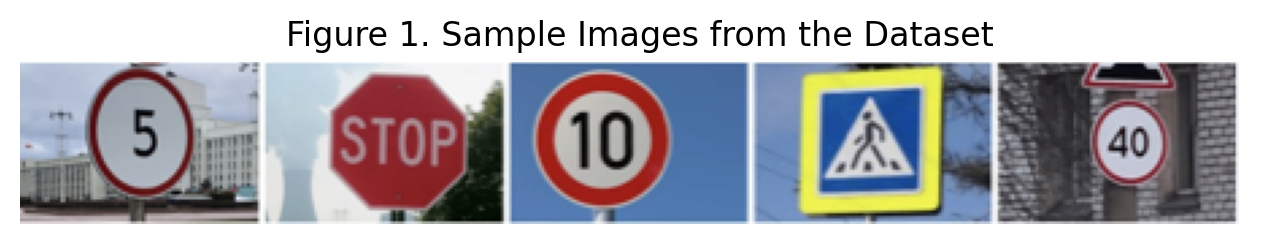

In [26]:
img = Image.open("../report/report_images/sample_data_images.png")
plt.figure(figsize=(8, 8))
fig = plt.imshow(img)
plt.title("Figure 1. Sample Images from the Dataset")
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

(image obtained from [Kaggle](https://www.kaggle.com/datasets/andrewmvd/road-sign-detection))

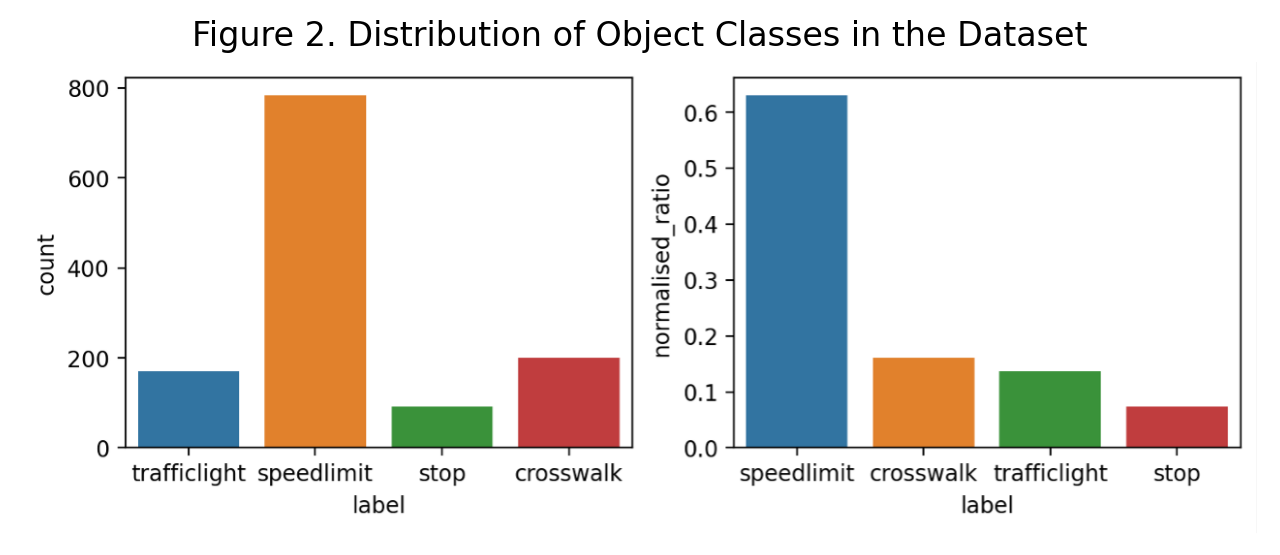

In [24]:
img = Image.open("../report/report_images/data_distribution.png")
plt.figure(figsize=(8, 8))
plt.title("Figure 2. Distribution of Object Classes in the Dataset")
fig = plt.imshow(img)
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

#### 2.1.2. Data Preprocessing

The data was split into a training and a validation set with the ratio of 4:1. As a result, the training set contained 701 images and the validation set had 176. Additionally, since the original format of the annotations were not ready to be used in the training pipeline, label format conversion was performed. Since the models used in the experiments required two different training frameworks, there were two types of conversion. The first framework was the `TensorFlow object detection API` which required the annotations in `TFRecord` format, while the Ultralytics framework for `YOLOv5` expected the annotations in text format with each line describing the bounding boxes of the objects. More details of the frameworks are discussed in **Section 2.2**. It is notable that the training and validation sets had separate annotation conversion, so that resulting files were distinctly addressed in the training configuration to be the training and validation annotations respectively. Further details of the data preprocessing steps can be found in the experimental Jupyter notebooks.

#### 2.1.3. Data Augmentation

Data augmentation is a technique that helps diversify the training data by adding variations to the images. For fair benchmarking and evaluation, similar augmentations had to be used in both frameworks (e.g., if the `TensorFlow` models used shearing at 30 degree, `YOLOv5` had to use the same transformation), meaning that we could only choose the augmentation options that were available in both frameworks. Additionally, in the context of traffic sign detection, some transformations would not be applicable such as vertical or horizontal flips, or 90 degree rotation. Due to these requirements, there were a limited number of options available that could be utilized. In this project, we could select only one augmentation option that fitted the situation, and it was image scaling (Figure 3, Figure 4). Nevertheless, this single augmentation proved to be effective as described in detail in a later section of this report.

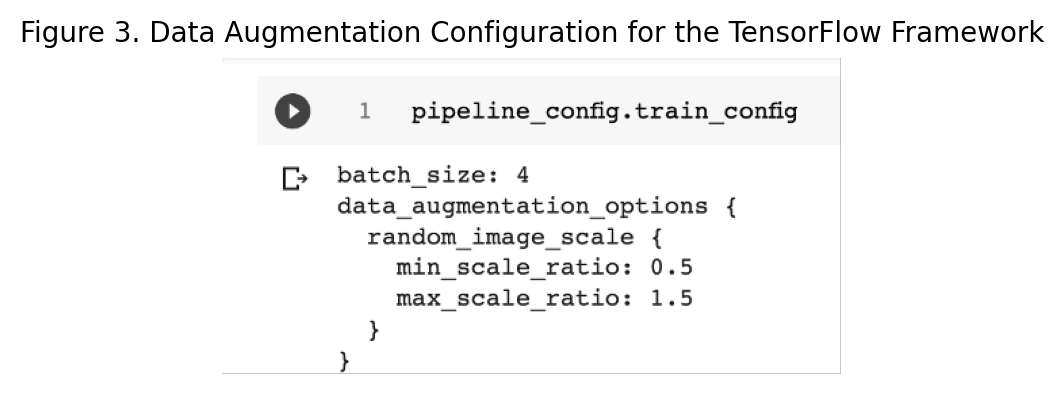

In [29]:
img = Image.open("../report/report_images/augmentation_tf.png")
plt.figure(figsize=(4, 4))
fig = plt.imshow(img)
plt.title("Figure 3. Data Augmentation Configuration for the TensorFlow Framework", size=10)
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

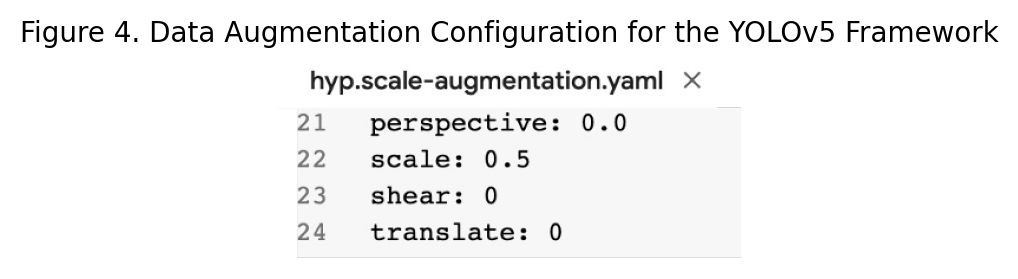

In [30]:
img = Image.open("../report/report_images/augmentation_yolo.png")
plt.figure(figsize=(3, 3))
fig = plt.imshow(img)
plt.title("Figure 4. Data Augmentation Configuration for the YOLOv5 Framework", size=10)
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

### 2.2. Models and Frameworks

#### 2.2.1.	Single Shot MultiBox Detector (SSD)

The Single Shot MultiBox Detector was firstly introduced in 2015 (Liu et al., 2015). This CNN architecture employs a set of default boxes of various aspect ratios and scales which, upon inference, can be adjusted to match the object shapes for better detection. Moreover, to cope with objects of different sizes, it leverages the fact that different feature maps have different resolutions, and therefore uses multiple predictions from these layers to compute the final detections. `Figure 5` describes the working mechanism of an SSD network and is taken from the original paper. Note that in `Figure 5(a)` there are two objects of different shapes and sizes, of which smaller object can be better detected with the blue default box on a higher resolution feature map (`Figure 5(b)`), while the location of the larger object would be more efficiently detected by the red default box on a lower resolution one (`Figure 5(c)`).

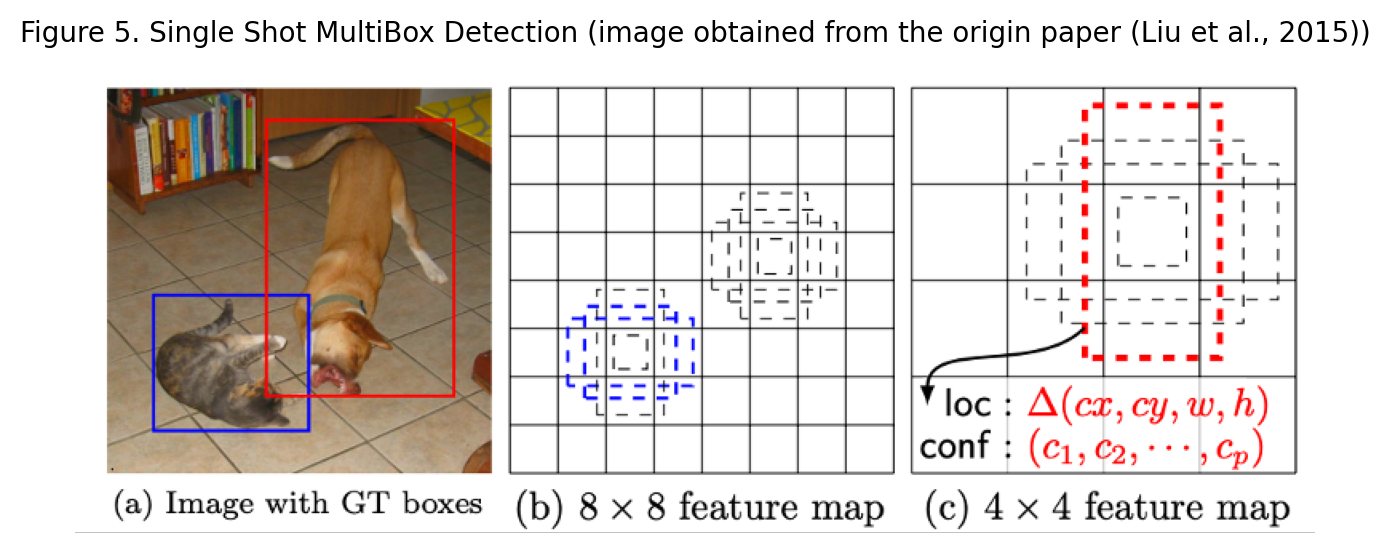

In [37]:
img = Image.open("../report/report_images/ssd.png")
plt.figure(figsize=(8, 8))
plt.title("Figure 5. Single Shot MultiBox Detection (image obtained from the origin paper (Liu et al., 2015))", size=10)
fig = plt.imshow(img)
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

### 2.2.2. Faster R-CNN

A competitor of the SSD family is the Faster Region-based Convolutional Neural Networks (Faster R-CNN), which was introduced also in 2015 (Ren et al., 2015). Unlike SSD models, R-CNNs are two-stage object detection algorithms that (1) produce region proposals that suggest the location of the objects based on which (2) boundary boxes and objectness scores are predicted. In Faster R-CNN architecture, the author introduced a Region Proposal Network (RPN) that address the model’s slow runtime issue which had been the bottleneck of any two-stage object detection networks.

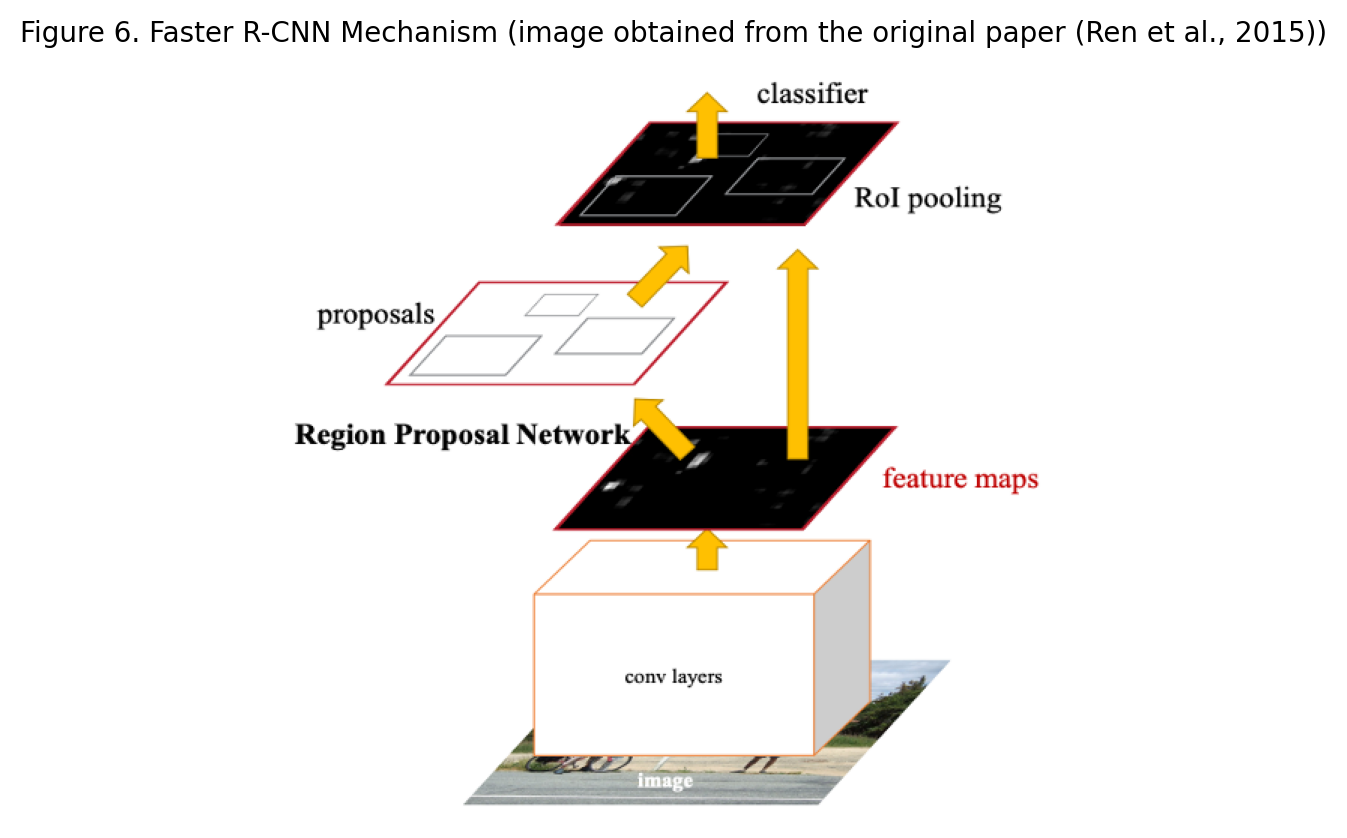

In [38]:
img = Image.open("../report/report_images/faster_rcnn.png")
plt.figure(figsize=(5, 5))
fig = plt.imshow(img)
plt.title("Figure 6. Faster R-CNN Mechanism (image obtained from the original paper (Ren et al., 2015))", size=10)
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)